#### This notebook demonstrates the use of a reweighing pre-processing algorithm for bias mitigation


In [77]:
%matplotlib inline
# Load all necessary packages
import sys
sys.path.insert(0, '/home/jl0274/AIF360')
import numpy as np
from tqdm import tqdm

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
        import load_preproc_data_adult
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

from IPython.display import Markdown, display
import matplotlib.pyplot as plt

from common_utils import compute_metrics
from joblib import Parallel, delayed
from scipy.stats import chi2_contingency
from statsmodels.stats.proportion import proportions_ztest

In [78]:
import aif360
aif360.__file__

'/home/jl0274/AIF360/aif360/__init__.py'

#### Load dataset and set options

In [79]:
## import dataset
dataset_used = "adult" # "adult", "german", "compas"
protected_attribute_used = 1 # 1, 2


if dataset_used == "adult":
#     dataset_orig = AdultDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_adult(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_adult(['race'])
    
elif dataset_used == "german":
#     dataset_orig = GermanDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_german(['sex'])
    else:
        privileged_groups = [{'age': 1}]
        unprivileged_groups = [{'age': 0}]
        dataset_orig = load_preproc_data_german(['age'])
    
elif dataset_used == "compas":
#     dataset_orig = CompasDataset()
    if protected_attribute_used == 1:
        privileged_groups = [{'sex': 1}]
        unprivileged_groups = [{'sex': 0}]
        dataset_orig = load_preproc_data_compas(['sex'])
    else:
        privileged_groups = [{'race': 1}]
        unprivileged_groups = [{'race': 0}]
        dataset_orig = load_preproc_data_compas(['race'])

all_metrics =  ["Statistical parity difference",
                   "Average odds difference",
                   "Equal opportunity difference"]

#random seed for calibrated equal odds prediction
np.random.seed(1)

standard dataset: is na? False


#### Split into train, and test

In [80]:
# Get the dataset and split into train and test
dataset_orig_train, dataset_orig_vt = dataset_orig.split([0.7], shuffle=True)
dataset_orig_valid, dataset_orig_test = dataset_orig_vt.split([0.5], shuffle=True)

#### Clean up training data

In [81]:
# print out some labels, names, etc.
display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, 
      dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(827046, 21)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex']


#### Privileged and unprivileged protected attribute values

[array([0.])] [array([1.])]


#### Dataset feature names

['hoepa_status_2.0', 'hoepa_status_3.0', 'total_loan_costs', 'rate_spread', 'interest_rate', 'origination_charges', 'lender_credits', 'derived_dwelling_category_Single Family (1-4 Units):Site-Built', 'loan_term', 'discount_points', 'construction_method_2.0', 'tract_to_msa_income_percentage', 'combined_loan_to_value_ratio', 'tract_population', 'tract_minority_population_percent', 'property_value', 'tract_owner_occupied_units', 'tract_one_to_four_family_homes', 'purchaser_type_1.0', 'income', 'sex']


#### Metric for original training data

In [82]:
# Metric for the original dataset
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig_train, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.053654


#### Train with and transform the original training data

In [83]:
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(dataset_orig_train)
dataset_transf_train = RW.transform(dataset_orig_train)

In [84]:
### Testing 
assert np.abs(dataset_transf_train.instance_weights.sum()-dataset_orig_train.instance_weights.sum())<1e-6

#### Metric with the transformed training data

In [85]:
metric_transf_train = BinaryLabelDatasetMetric(dataset_transf_train, 
                                         unprivileged_groups=unprivileged_groups,
                                         privileged_groups=privileged_groups)
display(Markdown("#### Transformed training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_transf_train.mean_difference())

#### Transformed training dataset

Difference in mean outcomes between unprivileged and privileged groups = 0.000000


In [86]:
### Testing 
assert np.abs(metric_transf_train.mean_difference()) < 1e-6

## Gender Present

### Train classifier on original data

In [87]:
# SVC and predictions
X_train = dataset_orig_train.features
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()

# svc.fit(X_train, y_train, 
         # sample_weight=dataset_orig_train.instance_weights)
y_train_pred = svc.predict(X_train)

# positive class index
pos_ind = np.where(svc.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 56.55, NNZs: 21, Bias: 13.554622, T: 661636, Avg. loss: 0.130038
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 56.70, NNZs: 21, Bias: 13.595050, T: 1323272, Avg. loss: 0.111416
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 56.83, NNZs: 21, Bias: 13.604964, T: 1984908, Avg. loss: 0.109888
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 56.94, NNZs: 21, Bias: 13.601016, T: 2646544, Avg. loss: 0.109119
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 57.03, NNZs: 21, Bias: 13.614893, T: 3308180, Avg. loss: 0.108653
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 57.11, NNZs: 21, Bias: 13.622229, T: 3969816, Avg. loss: 0.108349
Total training time: 0.46 seconds.
-- Epoch 7
Norm: 57.18, NNZs: 21, Bias: 13.606219, T: 4631452, Avg. loss: 0.108143
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 57.24, NNZs: 21, Bias: 13.617122, T: 5293088, Avg. loss: 0.107999
Total training time: 0.61 seconds.
Convergence after 8 epochs took 0.61 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


#### Obtain scores for original validation and test sets

In [88]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = svc.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = svc.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [89]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.9700
Optimal classification threshold (no reweighing) = 0.5643


### Predictions from the original test set at the optimal classification threshold

In [90]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5643


 60%|██████    | 60/100 [00:03<00:02, 16.29it/s]

Balanced accuracy = 0.9698
Statistical parity difference = 0.0455
Disparate impact = 1.0662
Average odds difference = -0.0008
Equal opportunity difference = -0.0046
Theil index = 0.0420


100%|██████████| 100/100 [00:06<00:00, 16.30it/s]


In [91]:
# inputs should be y_test, dataset_orig_test_pred.labels, dataset_orig_test_pred.scores respectively 
def accuracy_scores(y_true, preds, y_pred_scores, best_class_thresh):
    # F1 score
    y_pred = (y_pred_scores > best_class_thresh).astype(int)
    y_pred[y_pred == 1] = preds.favorable_label
    y_pred[y_pred == 0] = preds.unfavorable_label
    f1 = f1_score(y_true, y_pred)
    print(f"F1 Score: {f1:.4f}")
    # AUC
    auc = roc_auc_score(y_true, dataset_orig_test_pred.scores)
    print(f"ROC AUC Score: {auc:.4f}")
    
    return f1, auc
    
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9714
ROC AUC Score: 0.9895


In [92]:
# bias summary metrics
def bias_summary_metrics(gender_col, target):
    # test whether loan approval significantly depends on gender
    gender_col = pd.Series(gender_col)  # Convert gender to categorical
    target = pd.Series(target.ravel())

    # Create a contingency table
    contingency_table = pd.crosstab(gender_col, target)
    
    # Perform the Chi-Square test
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)
    
    print(f"Chi-Square Statistic: {chi2}")
    print(f"P-value: {p_value}")
    
    if p_value < 0.05:
        print("There is a significant association between gender and loan approval.")
    else:
        print("There is no significant association between gender and loan approval.")

    # test whether there's a significant difference in loan approval proportions across men vs women

    # Count of approvals for men and women
    men_approved = sum((gender_col == 0) & (target == 1))
    women_approved = sum((gender_col == 1) & (target == 1))
    
    # Total number of applicants in each group
    men_total = sum(gender_col == 0)
    women_total = sum(gender_col == 1)
    
    # Run the Z-test
    count = [men_approved, women_approved]
    nobs = [men_total, women_total]
    stat, p_value = proportions_ztest(count, nobs)
    
    print(f"Z-statistic: {stat}")
    print(f"P-value: {p_value:10e}")
    
    if p_value < 0.05:
        print("There is a significant difference in loan approval rates between men and women.")
    else:
        print("There is no significant difference in loan approval rates between men and women.")

    men_approved_prop = men_approved/men_total
    women_approved_prop = women_approved/women_total
    print(f'male approval rate: {men_approved_prop}')
    print(f'female approval rate: {women_approved_prop}')
    

In [93]:
bias_summary_metrics(X_test[:, -1], y_test)

Chi-Square Statistic: 347.3483495004508
P-value: 1.6016966173481337e-77
There is a significant association between gender and loan approval.
Z-statistic: 18.642745687474676
P-value: 1.446235e-77
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7189440052643883
female approval rate: 0.6765210911682757


#### Display results for all thresholds

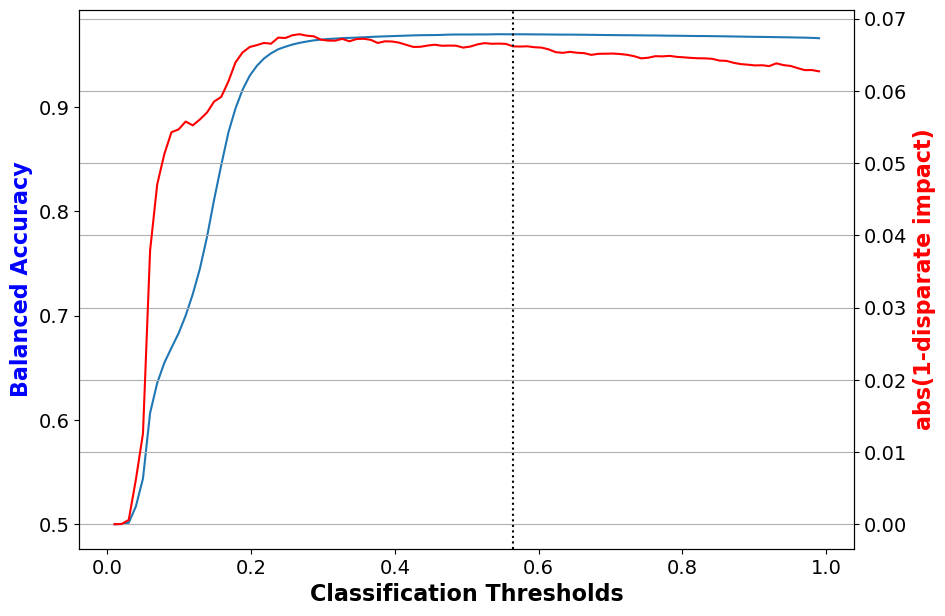

In [94]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-di-orig-gen')

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

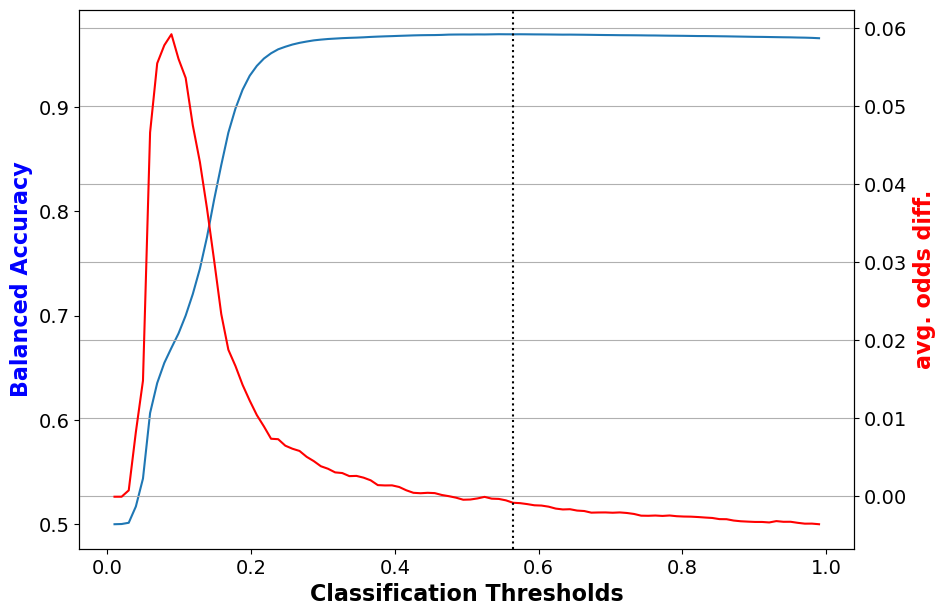

In [95]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-aodds-orig-gen')

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [96]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()
y_train_pred = svc.predict(X_train)

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 51.12, NNZs: 21, Bias: 14.933221, T: 661636, Avg. loss: 0.130949
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 51.30, NNZs: 21, Bias: 14.962741, T: 1323272, Avg. loss: 0.111356
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 51.46, NNZs: 21, Bias: 14.948973, T: 1984908, Avg. loss: 0.109799
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 51.58, NNZs: 21, Bias: 14.959562, T: 2646544, Avg. loss: 0.109008
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 51.69, NNZs: 21, Bias: 14.967169, T: 3308180, Avg. loss: 0.108514
Total training time: 0.39 seconds.
-- Epoch 6
Norm: 51.78, NNZs: 21, Bias: 14.967835, T: 3969816, Avg. loss: 0.108192
Total training time: 0.47 seconds.
-- Epoch 7
Norm: 51.86, NNZs: 21, Bias: 14.981652, T: 4631452, Avg. loss: 0.107967
Total training time: 0.55 seconds.
-- Epoch 8
Norm: 51.93, NNZs: 21, Bias: 14.979057, T: 5293088, Avg. loss: 0.107812
Total training time: 0.62 seconds.
Convergence after 8 epochs took 0.62 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


#### Obtain scores for transformed test set

In [97]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = svc.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [98]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5643


 60%|██████    | 60/100 [00:04<00:02, 14.97it/s]

Balanced accuracy = 0.9701
Statistical parity difference = 0.0452
Disparate impact = 1.0658
Average odds difference = -0.0012
Equal opportunity difference = -0.0048
Theil index = 0.0422


100%|██████████| 100/100 [00:06<00:00, 15.24it/s]


In [99]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, best_class_thresh)

F1 Score: 0.9713
ROC AUC Score: 0.9895


In [100]:
bias_summary_metrics(X_test[:, -1], y_test)

Chi-Square Statistic: 347.897861438135
P-value: 1.2159450372957603e-77
There is a significant association between gender and loan approval.
Z-statistic: 18.65748174415752
P-value: 1.097844e-77
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7188833955304651
female approval rate: 0.6764238968444243


#### Display results for all thresholds

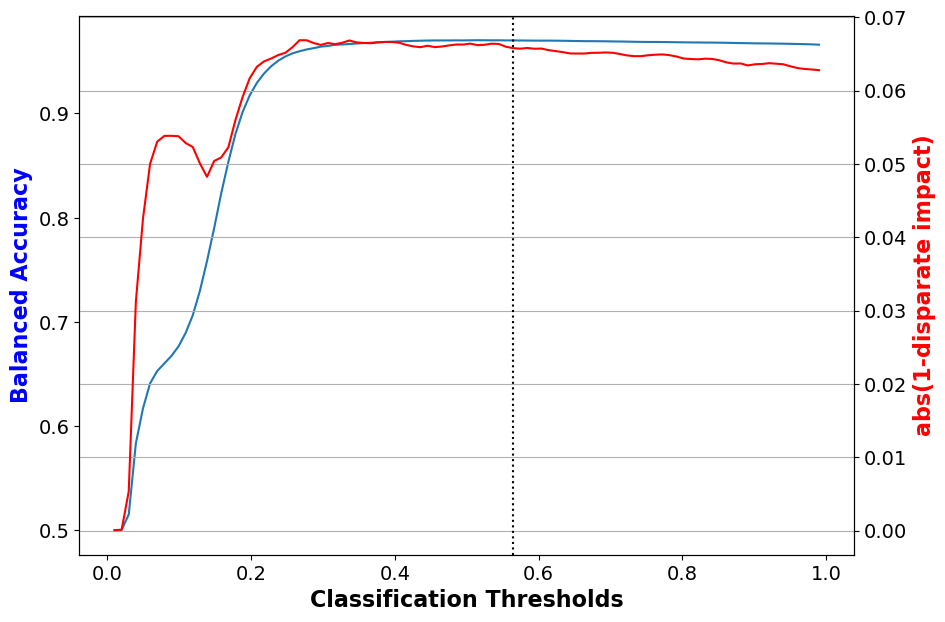

In [101]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-di-transf-gen')

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

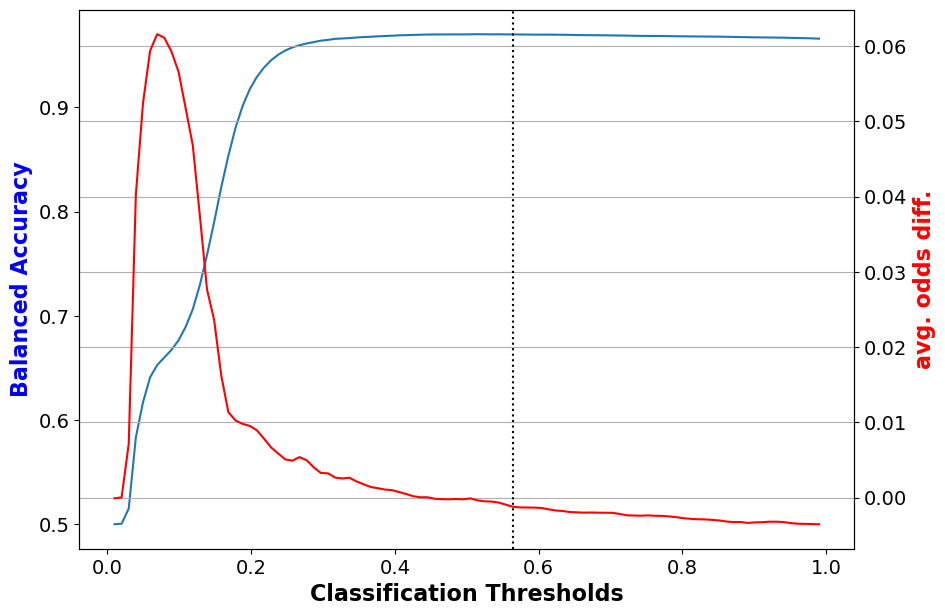

In [102]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-aodds-transf-gen')

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

## Gender Not Present

### Train classifier on original data

In [103]:
gender_col = X_test[:, -1]

In [104]:
# Logistic regression classifier and predictions
X_train = dataset_orig_train.features[:, :-1]
y_train = dataset_orig_train.labels.ravel()
w_train = dataset_orig_train.instance_weights.ravel()

svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()
y_train_pred = svc.predict(X_train)

# positive class index
pos_ind = np.where(svc.classes_ == dataset_orig_train.favorable_label)[0][0]

dataset_orig_train_pred = dataset_orig_train.copy()
dataset_orig_train_pred.labels = y_train_pred

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 43.76, NNZs: 20, Bias: 10.789545, T: 661636, Avg. loss: 0.129108
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 43.95, NNZs: 20, Bias: 10.836170, T: 1323272, Avg. loss: 0.111316
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 44.11, NNZs: 20, Bias: 10.848722, T: 1984908, Avg. loss: 0.109783
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 44.25, NNZs: 20, Bias: 10.861595, T: 2646544, Avg. loss: 0.109007
Total training time: 0.30 seconds.
-- Epoch 5
Norm: 44.37, NNZs: 20, Bias: 10.858505, T: 3308180, Avg. loss: 0.108529
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 44.47, NNZs: 20, Bias: 10.867201, T: 3969816, Avg. loss: 0.108208
Total training time: 0.45 seconds.
-- Epoch 7
Norm: 44.57, NNZs: 20, Bias: 10.867344, T: 4631452, Avg. loss: 0.107999
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 44.65, NNZs: 20, Bias: 10.869571, T: 5293088, Avg. loss: 0.107845
Total training time: 0.60 seconds.
Convergence after 8 epochs took 0.60 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.22s/it]


#### Obtain scores for original validation and test sets

In [105]:
dataset_orig_valid_pred = dataset_orig_valid.copy(deepcopy=True)
X_valid = dataset_orig_valid_pred.features[:, :-1]
y_valid = dataset_orig_valid_pred.labels
dataset_orig_valid_pred.scores = svc.predict_proba(X_valid)[:,pos_ind].reshape(-1,1)

dataset_orig_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_orig_test_pred.features[:, :-1]
y_test = dataset_orig_test_pred.labels
dataset_orig_test_pred.scores = svc.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Find the optimal classification threshold from the validation set

In [106]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)
for idx, class_thresh in enumerate(class_thresh_arr):
    
    fav_inds = dataset_orig_valid_pred.scores > class_thresh
    dataset_orig_valid_pred.labels[fav_inds] = dataset_orig_valid_pred.favorable_label
    dataset_orig_valid_pred.labels[~fav_inds] = dataset_orig_valid_pred.unfavorable_label
    
    classified_metric_orig_valid = ClassificationMetric(dataset_orig_valid,
                                             dataset_orig_valid_pred, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
    
    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.9708
Optimal classification threshold (no reweighing) = 0.5742


### Predictions from the original test set at the optimal classification threshold

In [107]:
display(Markdown("#### Predictions from original testing data"))
bal_acc_arr_orig = []
disp_imp_arr_orig = []
avg_odds_diff_arr_orig = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_orig_test_pred.scores > thresh
    dataset_orig_test_pred.labels[fav_inds] = dataset_orig_test_pred.favorable_label
    dataset_orig_test_pred.labels[~fav_inds] = dataset_orig_test_pred.unfavorable_label
    
    metric_test_bef = compute_metrics(dataset_orig_test, dataset_orig_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_orig.append(metric_test_bef["Balanced accuracy"])
    avg_odds_diff_arr_orig.append(metric_test_bef["Average odds difference"])
    disp_imp_arr_orig.append(metric_test_bef["Disparate impact"])

#### Predictions from original testing data

Classification threshold used = 0.5742


 60%|██████    | 60/100 [00:03<00:02, 16.07it/s]

Balanced accuracy = 0.9707
Statistical parity difference = 0.0459
Disparate impact = 1.0667
Average odds difference = -0.0002
Equal opportunity difference = -0.0044
Theil index = 0.0403


100%|██████████| 100/100 [00:06<00:00, 16.14it/s]


In [108]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_orig_test_pred, dataset_orig_test_pred.scores, best_class_thresh)

F1 Score: 0.9725
ROC AUC Score: 0.9899


In [109]:
bias_summary_metrics(gender_col, y_test)

Chi-Square Statistic: 351.78729339172287
P-value: 1.729553262559934e-78
There is a significant association between gender and loan approval.
Z-statistic: 18.761458907883974
P-value: 1.560568e-78
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7196886391383027
female approval rate: 0.6770232618415084


#### Display results for all thresholds

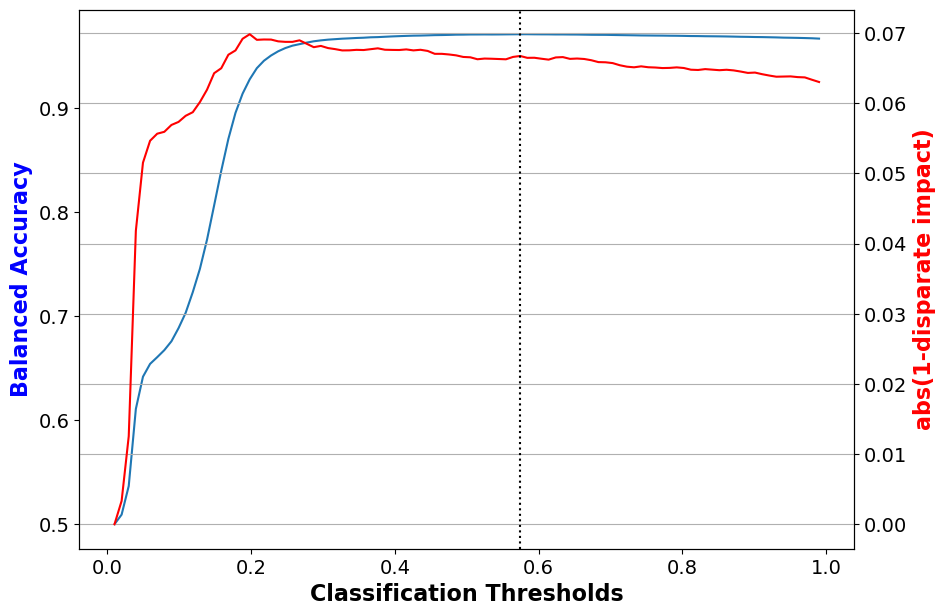

In [110]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_orig)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-di-orig-nogen')

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

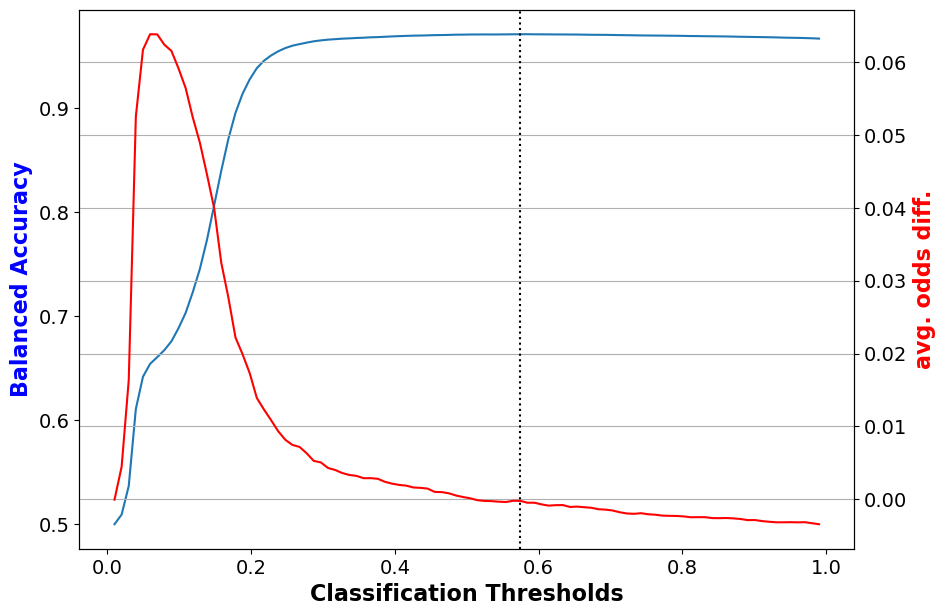

In [111]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_orig)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_orig, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-aodds-orig-nogen')

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

However, for a classifier trained with original training data, at the best classification rate, this is quite high. This implies unfairness.

### Train classifier on transformed data

In [112]:
X_train = dataset_transf_train.features
y_train = dataset_transf_train.labels.ravel()

svc = SGDClassifier(loss='hinge', penalty=None, alpha=0.0001, verbose=True)
svc = CalibratedClassifierCV(svc, method="sigmoid", cv=5)

with tqdm(total=1, desc="Training SVC") as pbar:
    svc.fit(X_train, y_train, sample_weight=dataset_orig_train.instance_weights)
    pbar.update()
y_train_pred = svc.predict(X_train)

Training SVC:   0%|          | 0/1 [00:00<?, ?it/s]

-- Epoch 1
Norm: 48.82, NNZs: 21, Bias: 10.878048, T: 661636, Avg. loss: 0.130304
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 49.00, NNZs: 21, Bias: 10.929152, T: 1323272, Avg. loss: 0.111345
Total training time: 0.15 seconds.
-- Epoch 3
Norm: 49.16, NNZs: 21, Bias: 10.907139, T: 1984908, Avg. loss: 0.109824
Total training time: 0.23 seconds.
-- Epoch 4
Norm: 49.28, NNZs: 21, Bias: 10.928949, T: 2646544, Avg. loss: 0.109075
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 49.39, NNZs: 21, Bias: 10.922162, T: 3308180, Avg. loss: 0.108612
Total training time: 0.38 seconds.
-- Epoch 6
Norm: 49.48, NNZs: 21, Bias: 10.928247, T: 3969816, Avg. loss: 0.108302
Total training time: 0.46 seconds.
-- Epoch 7
Norm: 49.56, NNZs: 21, Bias: 10.928659, T: 4631452, Avg. loss: 0.108093
Total training time: 0.53 seconds.
-- Epoch 8
Norm: 49.64, NNZs: 21, Bias: 10.931046, T: 5293088, Avg. loss: 0.107951
Total training time: 0.61 seconds.
Convergence after 8 epochs took 0.61 seconds
-- Epoch 1
N

Training SVC: 100%|██████████| 1/1 [00:04<00:00,  4.24s/it]


#### Obtain scores for transformed test set

In [113]:
dataset_transf_test_pred = dataset_orig_test.copy(deepcopy=True)
X_test = dataset_transf_test_pred.features
y_test = dataset_transf_test_pred.labels
dataset_transf_test_pred.scores = svc.predict_proba(X_test)[:,pos_ind].reshape(-1,1)

### Predictions from the transformed test set at the optimal classification threshold

In [114]:
display(Markdown("#### Predictions from transformed testing data"))
bal_acc_arr_transf = []
disp_imp_arr_transf = []
avg_odds_diff_arr_transf = []

print("Classification threshold used = %.4f" % best_class_thresh)
for thresh in tqdm(class_thresh_arr):
    
    if thresh == best_class_thresh:
        disp = True
    else:
        disp = False
    
    fav_inds = dataset_transf_test_pred.scores > thresh
    dataset_transf_test_pred.labels[fav_inds] = dataset_transf_test_pred.favorable_label
    dataset_transf_test_pred.labels[~fav_inds] = dataset_transf_test_pred.unfavorable_label
    
    metric_test_aft = compute_metrics(dataset_orig_test, dataset_transf_test_pred, 
                                      unprivileged_groups, privileged_groups,
                                      disp = disp)

    bal_acc_arr_transf.append(metric_test_aft["Balanced accuracy"])
    avg_odds_diff_arr_transf.append(metric_test_aft["Average odds difference"])
    disp_imp_arr_transf.append(metric_test_aft["Disparate impact"])

#### Predictions from transformed testing data

Classification threshold used = 0.5742


 60%|██████    | 60/100 [00:03<00:02, 16.20it/s]

Balanced accuracy = 0.9698
Statistical parity difference = 0.0473
Disparate impact = 1.0690
Average odds difference = 0.0009
Equal opportunity difference = -0.0027
Theil index = 0.0420


100%|██████████| 100/100 [00:06<00:00, 16.24it/s]


In [115]:
f1, auc = accuracy_scores(dataset_orig_test.labels, dataset_transf_test_pred, dataset_transf_test_pred.scores, best_class_thresh)

F1 Score: 0.9714
ROC AUC Score: 0.9899


In [116]:
bias_summary_metrics(gender_col, y_test)

Chi-Square Statistic: 349.7132103164146
P-value: 4.893191289423743e-78
There is a significant association between gender and loan approval.
Z-statistic: 18.70608299277515
P-value: 4.416683e-78
There is a significant difference in loan approval rates between men and women.
male approval rate: 0.7190998588659053
female approval rate: 0.6765372902222511


#### Display results for all thresholds

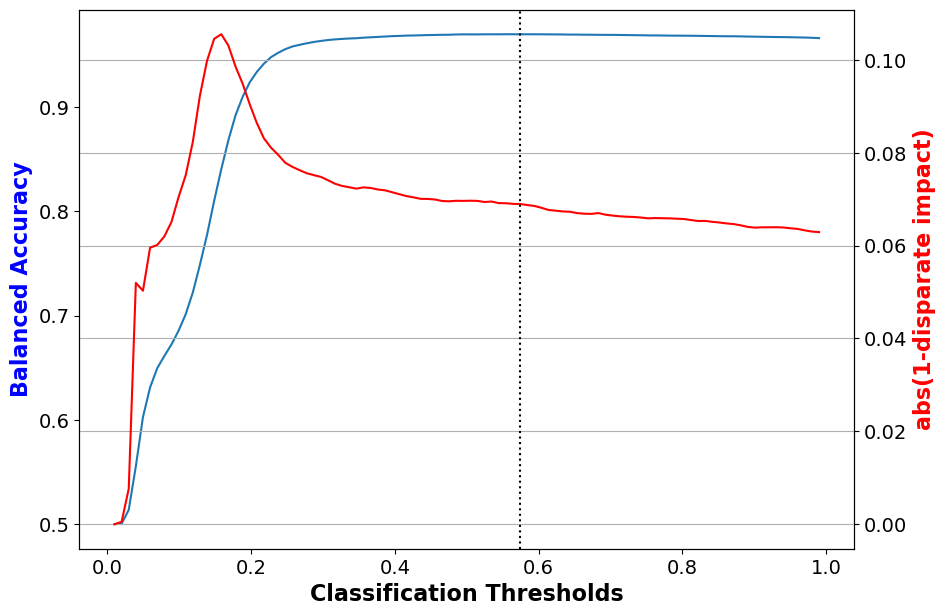

In [117]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, np.abs(1.0-np.array(disp_imp_arr_transf)), color='r')
ax2.set_ylabel('abs(1-disparate impact)', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-di-transf-nogen')

plt.show()

```abs(1-disparate impact)``` must be small (close to 0) for classifier predictions to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.

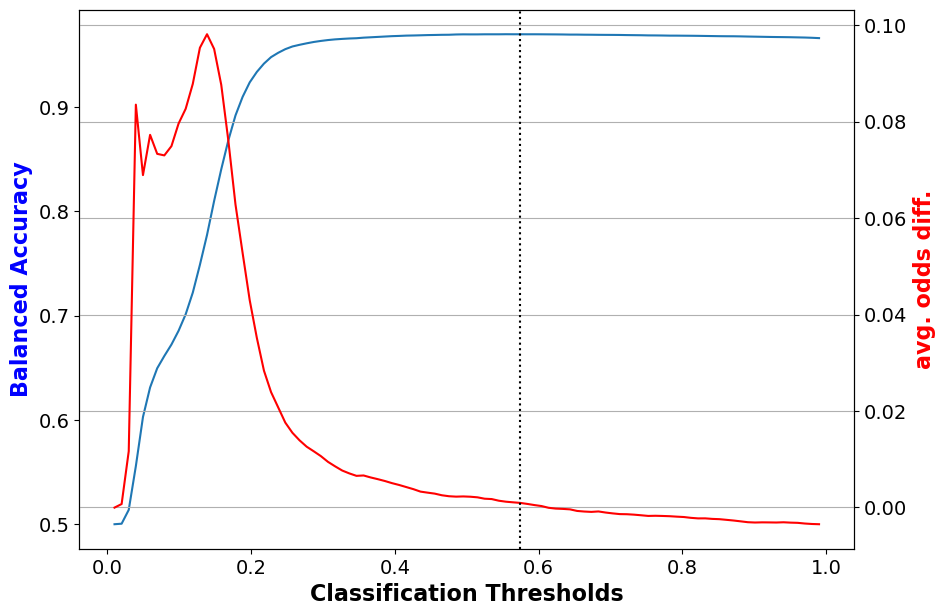

In [118]:
fig, ax1 = plt.subplots(figsize=(10,7))
ax1.plot(class_thresh_arr, bal_acc_arr_transf)
ax1.set_xlabel('Classification Thresholds', fontsize=16, fontweight='bold')
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=16, fontweight='bold')
ax1.xaxis.set_tick_params(labelsize=14)
ax1.yaxis.set_tick_params(labelsize=14)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, avg_odds_diff_arr_transf, color='r')
ax2.set_ylabel('avg. odds diff.', color='r', fontsize=16, fontweight='bold')
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=14)
ax2.grid(True)

plt.savefig('reweigh-svc-aodds-transf-nogen')

plt.show()

```average odds difference = 0.5((FPR_unpriv-FPR_priv)+(TPR_unpriv-TPR_priv))``` must be close to zero for the classifier to be fair.

For a classifier trained with reweighted training data, at the best classification rate, this is indeed the case.
This implies fairness.